# Peter và Chó Sói: Hướng dẫn cơ bản về Học tăng cường

Trong hướng dẫn này, chúng ta sẽ học cách áp dụng học tăng cường vào một bài toán tìm đường. Bối cảnh được lấy cảm hứng từ câu chuyện cổ tích âm nhạc [Peter và Chó Sói](https://en.wikipedia.org/wiki/Peter_and_the_Wolf) của nhà soạn nhạc người Nga [Sergei Prokofiev](https://en.wikipedia.org/wiki/Sergei_Prokofiev). Đây là câu chuyện về cậu bé tiên phong Peter, người dũng cảm rời khỏi nhà để đến khu rừng trống nhằm đuổi theo con sói. Chúng ta sẽ huấn luyện các thuật toán học máy để giúp Peter khám phá khu vực xung quanh và xây dựng một bản đồ điều hướng tối ưu.

Đầu tiên, hãy nhập một số thư viện hữu ích:


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math

## Tổng quan về Học tăng cường

**Học tăng cường** (Reinforcement Learning - RL) là một kỹ thuật học cho phép chúng ta tìm hiểu hành vi tối ưu của một **tác nhân** trong một **môi trường** nào đó bằng cách thực hiện nhiều thử nghiệm. Một tác nhân trong môi trường này cần có một **mục tiêu**, được xác định bởi một **hàm phần thưởng**.

## Môi trường

Để đơn giản, hãy xem xét thế giới của Peter là một bảng vuông có kích thước `width` x `height`. Mỗi ô trên bảng này có thể là:
* **mặt đất**, nơi Peter và các sinh vật khác có thể đi lại
* **nước**, nơi rõ ràng bạn không thể đi qua
* **một cái cây** hoặc **cỏ** - nơi bạn có thể nghỉ ngơi
* **một quả táo**, đại diện cho thứ mà Peter rất vui khi tìm thấy để tự nuôi sống mình
* **một con sói**, thứ nguy hiểm và cần phải tránh xa

Để làm việc với môi trường, chúng ta sẽ định nghĩa một lớp gọi là `Board`. Để tránh làm rối notebook này, chúng ta đã chuyển toàn bộ mã nguồn làm việc với bảng vào một module riêng tên là `rlboard`, mà bây giờ chúng ta sẽ import. Bạn có thể xem bên trong module này để tìm hiểu thêm chi tiết về cách triển khai nội bộ.


In [2]:
from rlboard import *

Bây giờ hãy tạo một bảng ngẫu nhiên và xem nó trông như thế nào:


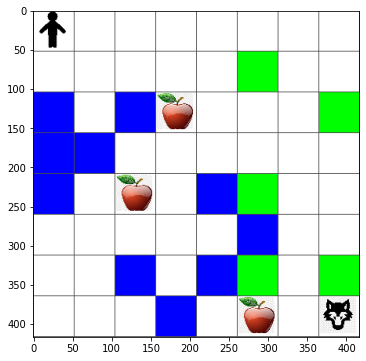

In [3]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

## Hành động và Chính sách

Trong ví dụ của chúng ta, mục tiêu của Peter là tìm một quả táo, đồng thời tránh con sói và các chướng ngại vật khác. Để làm được điều này, anh ấy có thể đi xung quanh cho đến khi tìm thấy một quả táo. Vì vậy, tại bất kỳ vị trí nào, anh ấy có thể chọn một trong các hành động sau: lên, xuống, trái và phải. Chúng ta sẽ định nghĩa các hành động này dưới dạng một từ điển và ánh xạ chúng tới các cặp thay đổi tọa độ tương ứng. Ví dụ, di chuyển sang phải (`R`) sẽ tương ứng với cặp tọa độ `(1,0)`.


In [4]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

Chiến lược của tác nhân (Peter) được định nghĩa bởi một cái gọi là **chính sách**. Hãy cùng xem xét chính sách đơn giản nhất được gọi là **đi ngẫu nhiên**.

## Đi ngẫu nhiên

Trước tiên, hãy giải quyết vấn đề của chúng ta bằng cách triển khai chiến lược đi ngẫu nhiên.


In [5]:
def random_policy(m):
    return random.choice(list(actions))

def walk(m,policy,start_position=None):
    n = 0 # number of steps
    # set initial position
    if start_position:
        m.human = start_position 
    else:
        m.random_start()
    while True:
        if m.at() == Board.Cell.apple:
            return n # success!
        if m.at() in [Board.Cell.wolf, Board.Cell.water]:
            return -1 # eaten by wolf or drowned
        while True:
            a = actions[policy(m)]
            new_pos = m.move_pos(m.human,a)
            if m.is_valid(new_pos) and m.at(new_pos)!=Board.Cell.water:
                m.move(a) # do the actual move
                break
        n+=1

walk(m,random_policy)

18

Hãy thực hiện thí nghiệm bước đi ngẫu nhiên nhiều lần và xem số bước trung bình đã thực hiện:


In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        else:
            s += z
            n += 1
    print(f"Average path length = {s/n}, eaten by wolf: {w} times")

print_statistics(random_policy)

Average path length = 32.87096774193548, eaten by wolf: 7 times


## Hàm Thưởng

Để làm cho chính sách của chúng ta thông minh hơn, chúng ta cần hiểu những nước đi nào "tốt hơn" so với những nước khác.


In [7]:
move_reward = -0.1
goal_reward = 10
end_reward = -10

def reward(m,pos=None):
    pos = pos or m.human
    if not m.is_valid(pos):
        return end_reward
    x = m.at(pos)
    if x==Board.Cell.water or x == Board.Cell.wolf:
        return end_reward
    if x==Board.Cell.apple:
        return goal_reward
    return move_reward

## Q-Learning

Xây dựng một Q-Table, hoặc mảng đa chiều. Vì bảng của chúng ta có kích thước `width` x `height`, chúng ta có thể biểu diễn Q-Table bằng một mảng numpy với hình dạng `width` x `height` x `len(actions)`:


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

Chuyển bảng Q-Table vào hàm vẽ để hiển thị bảng trên bảng:


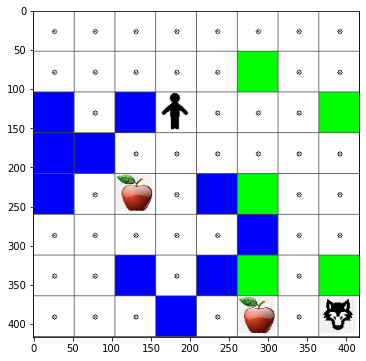

In [9]:
m.plot(Q)

## Bản chất của Q-Learning: Phương trình Bellman và Thuật toán Học

Viết mã giả cho thuật toán học của chúng ta:

* Khởi tạo Bảng Q Q với các giá trị bằng nhau cho tất cả các trạng thái và hành động
* Đặt tốc độ học $\alpha\leftarrow 1$
* Lặp lại mô phỏng nhiều lần
   1. Bắt đầu tại vị trí ngẫu nhiên
   1. Lặp lại
        1. Chọn một hành động $a$ tại trạng thái $s$
        2. Thực hiện hành động bằng cách di chuyển đến trạng thái mới $s'$
        3. Nếu gặp điều kiện kết thúc trò chơi, hoặc tổng phần thưởng quá nhỏ - thoát khỏi mô phỏng  
        4. Tính phần thưởng $r$ tại trạng thái mới
        5. Cập nhật Hàm Q theo phương trình Bellman: $Q(s,a)\leftarrow (1-\alpha)Q(s,a)+\alpha(r+\gamma\max_{a'}Q(s',a'))$
        6. $s\leftarrow s'$
        7. Cập nhật tổng phần thưởng và giảm $\alpha$.

## Khai thác vs. Khám phá

Cách tiếp cận tốt nhất là cân bằng giữa khám phá và khai thác. Khi chúng ta hiểu thêm về môi trường, chúng ta sẽ có xu hướng đi theo lộ trình tối ưu hơn, tuy nhiên, thỉnh thoảng vẫn nên chọn con đường chưa được khám phá.

## Triển khai Python

Bây giờ chúng ta đã sẵn sàng triển khai thuật toán học. Trước đó, chúng ta cũng cần một số hàm để chuyển đổi các số bất kỳ trong Bảng Q thành một vector xác suất cho các hành động tương ứng:


In [10]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

Chúng ta thêm một lượng nhỏ `eps` vào vector ban đầu để tránh việc chia cho 0 trong trường hợp ban đầu, khi tất cả các thành phần của vector đều giống nhau.

Thuật toán học thực tế mà chúng ta sẽ chạy trong 5000 thí nghiệm, còn được gọi là **epochs**:


In [11]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    m.random_start()
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        dpos = actions[a]
        m.move(dpos,check_correctness=False) # we allow player to move outside the board, which terminates episode
        r = reward(m)
        cum_reward += r
        if r==end_reward or cum_reward < -1000:
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

Sau khi thực hiện thuật toán này, Bảng Q nên được cập nhật với các giá trị xác định mức độ hấp dẫn của các hành động khác nhau tại mỗi bước. Hình dung bảng tại đây:


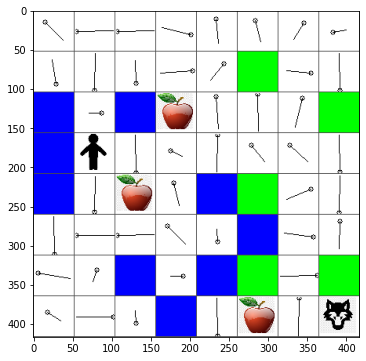

In [12]:
m.plot(Q)

## Kiểm tra Chính sách

Vì Q-Table liệt kê "sức hấp dẫn" của mỗi hành động tại mỗi trạng thái, nên việc sử dụng nó để xác định cách điều hướng hiệu quả trong thế giới của chúng ta là khá dễ dàng. Trong trường hợp đơn giản nhất, chúng ta chỉ cần chọn hành động tương ứng với giá trị cao nhất trong Q-Table:


In [13]:
def qpolicy_strict(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = list(actions)[np.argmax(v)]
        return a

walk(m,qpolicy_strict)

2

Nếu bạn thử đoạn mã trên nhiều lần, bạn có thể nhận thấy rằng đôi khi nó chỉ "treo" và bạn cần nhấn nút DỪNG trong notebook để ngắt nó.

> **Nhiệm vụ 1:** Sửa đổi hàm `walk` để giới hạn độ dài tối đa của đường đi bằng một số bước nhất định (ví dụ, 100), và quan sát đoạn mã trên trả về giá trị này theo thời gian.

> **Nhiệm vụ 2:** Sửa đổi hàm `walk` để không quay lại những nơi mà nó đã từng đi qua trước đó. Điều này sẽ ngăn `walk` lặp lại, tuy nhiên, tác nhân vẫn có thể bị "mắc kẹt" ở một vị trí mà nó không thể thoát ra được.


In [14]:

def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Average path length = 3.45, eaten by wolf: 0 times


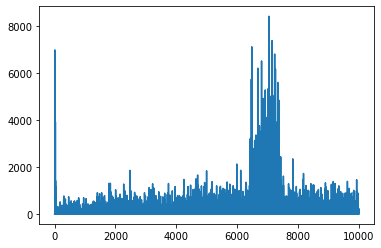

In [15]:
plt.plot(lpath)

Điều chúng ta thấy ở đây là ban đầu độ dài trung bình của đường đi tăng lên. Điều này có thể là do khi chúng ta chưa biết gì về môi trường - chúng ta dễ bị mắc kẹt trong các trạng thái xấu, như nước hoặc sói. Khi chúng ta học được nhiều hơn và bắt đầu sử dụng kiến thức này, chúng ta có thể khám phá môi trường lâu hơn, nhưng vẫn chưa biết rõ vị trí của những quả táo.

Khi học đủ, việc đạt được mục tiêu trở nên dễ dàng hơn đối với tác nhân, và độ dài đường đi bắt đầu giảm. Tuy nhiên, chúng ta vẫn mở rộng khám phá, vì vậy thường đi lệch khỏi đường đi tốt nhất và thử nghiệm các lựa chọn mới, khiến đường đi dài hơn mức tối ưu.

Điều chúng ta cũng quan sát được trên biểu đồ này là tại một số điểm, độ dài tăng đột ngột. Điều này cho thấy tính chất ngẫu nhiên của quá trình, và rằng tại một số thời điểm chúng ta có thể "làm hỏng" các hệ số trong Q-Table bằng cách ghi đè chúng với các giá trị mới. Điều này lý tưởng nên được giảm thiểu bằng cách giảm tốc độ học (tức là, về cuối quá trình huấn luyện, chúng ta chỉ điều chỉnh các giá trị trong Q-Table bằng một giá trị nhỏ).

Nhìn chung, điều quan trọng cần nhớ là sự thành công và chất lượng của quá trình học phụ thuộc đáng kể vào các tham số, như tốc độ học, sự giảm tốc độ học và hệ số chiết khấu. Những tham số này thường được gọi là **siêu tham số**, để phân biệt với **tham số** mà chúng ta tối ưu trong quá trình huấn luyện (ví dụ: các hệ số trong Q-Table). Quá trình tìm giá trị tốt nhất cho các siêu tham số được gọi là **tối ưu hóa siêu tham số**, và nó xứng đáng là một chủ đề riêng.


## Bài Tập
#### Một Thế Giới Peter và Con Sói Thực Tế Hơn

Trong tình huống của chúng ta, Peter có thể di chuyển gần như không bị mệt mỏi hay đói. Trong một thế giới thực tế hơn, cậu ấy phải ngồi xuống nghỉ ngơi thỉnh thoảng và cũng cần ăn uống để duy trì sức khỏe. Hãy làm cho thế giới của chúng ta thực tế hơn bằng cách thực hiện các quy tắc sau:

1. Khi di chuyển từ nơi này sang nơi khác, Peter mất **năng lượng** và tăng thêm **mệt mỏi**.
2. Peter có thể tăng năng lượng bằng cách ăn táo.
3. Peter có thể giảm mệt mỏi bằng cách nghỉ ngơi dưới gốc cây hoặc trên cỏ (tức là đi vào vị trí trên bảng có cây hoặc cỏ - ô màu xanh lá).
4. Peter cần tìm và tiêu diệt con sói.
5. Để tiêu diệt con sói, Peter cần đạt mức năng lượng và mệt mỏi nhất định, nếu không cậu ấy sẽ thua trong trận chiến.

Hãy chỉnh sửa hàm thưởng ở trên theo các quy tắc của trò chơi, chạy thuật toán học tăng cường để tìm chiến lược tốt nhất để chiến thắng trò chơi, và so sánh kết quả của việc đi ngẫu nhiên với thuật toán của bạn về số lượng trò chơi thắng và thua.

> **Note**: Bạn có thể cần điều chỉnh các siêu tham số để làm cho nó hoạt động, đặc biệt là số lượng epochs. Vì thành công của trò chơi (đánh bại con sói) là một sự kiện hiếm gặp, bạn có thể mong đợi thời gian huấn luyện lâu hơn.



---

**Tuyên bố miễn trừ trách nhiệm**:  
Tài liệu này đã được dịch bằng dịch vụ dịch thuật AI [Co-op Translator](https://github.com/Azure/co-op-translator). Mặc dù chúng tôi cố gắng đảm bảo độ chính xác, xin lưu ý rằng các bản dịch tự động có thể chứa lỗi hoặc không chính xác. Tài liệu gốc bằng ngôn ngữ bản địa nên được coi là nguồn thông tin chính thức. Đối với các thông tin quan trọng, khuyến nghị sử dụng dịch vụ dịch thuật chuyên nghiệp bởi con người. Chúng tôi không chịu trách nhiệm cho bất kỳ sự hiểu lầm hoặc diễn giải sai nào phát sinh từ việc sử dụng bản dịch này.
